In [1]:
import numpy as np
from numpy import random 
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

seed = 0
random.seed(seed)

In [2]:
df = pd.read_csv('proximian.csv')

In [3]:
df.columns = np.array(['time', 'velocity', 'error'])
df = df.sort_values(by=['time'])

In [4]:
def sin_function(hyperparam, x=df.time):
    """
    Functional form to estimate. 
    
    Parameters
    ----------
    
    x: array, shape = (n_samples, )
        Input values
    
    hyperparam: array, shape = (3, )
        Hyperparameters, P, K, phi
    
    Returns
    -------
    
    y: array, shape = (n_samples, )
        Output values from the specified functional form
    
    """
    
    x = np.array(x)
    P = hyperparam[0]
    K = hyperparam[1]
    phi = hyperparam[2]
    y = K * np.sin(P*x + phi)
    
    return y

In [5]:
def get_error(f_pred, obs=df.velocity):
    """
    Calculate the error (sum of squares) between observed data and data given by the estimated function. 
    
    Parameters
    ----------
    
    obs: array, shape = (n_samples, )
        Observed data. 
        
    f_pred: array, shape = (n_samples, )
        Data calculated according to the estimated function. 
        
    Returns
    -------
    
    ss: float
        Sum of squares of difference between obs and func. 
    """
    
    ss = np.sum(np.square(obs - f_pred))
    
    return ss
    

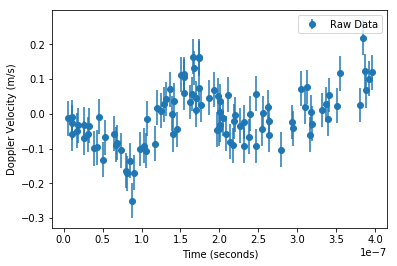

In [6]:
fig, axes = plt.subplots()
axes.errorbar(x=df['time'], y=df['velocity'], yerr=df['error'], fmt='o', label='Raw Data')
axes.set_xlabel('Time (seconds)')
axes.set_ylabel('Doppler Velocity (m/s)')
axes.legend()
plt.show()

In [7]:
hyperparam_arr = np.array([[1e7, 1.0 , 0.0  ], 
                           [1e6, 0.01, 0.0  ], 
                           [5e7, 2.0 , np.pi]])

for hyperparam in hyperparam_arr:
    print('Hyperparameters: {}'.format(hyperparam))
    print('Error: {}'.format(get_error(sin_function(hyperparam))))

Hyperparameters: [1.e+07 1.e+00 0.e+00]
Error: 54.5633088200126
Hyperparameters: [1.e+06 1.e-02 0.e+00]
Error: 0.6623217450304874
Hyperparameters: [5.00000000e+07 2.00000000e+00 3.14159265e+00]
Error: 209.12908243515417


In [8]:
def evaluate(population, obs=df.velocity, x=df.time):
    """
    Evaluate function for genetic algorithm. 
    
    Parameters
    ----------
    
    population: Dataframe
        Population for genetic algorithm
        
    obs: array, shape = (n_samples, )
        Observed data. 
        
    x: array, shape = (n_samples, )
        Input values
        
    Returns
    -------
    
    population: Dataframe
        Population dataframe with an added column named 'fitness', the negative error
    """
    
    hyperparam = np.array([population.P.values, population.K.values, population.phi.values]).T
    fitness = np.array([-get_error(sin_function(hyperparam[i])) for i in range(hyperparam.shape[0])])
    population['fitness'] = fitness
    
    return population

In [9]:
def tournament(population, N_tournaments, win_rate=0.75):
    """
    
    Tournament to create the gene pool for a new population. 
    
    Parameters
    ----------
    
    population: Dataframe
        Population for genetic algorithm.
        
    N_tournaments: int
        Number of tournaments to be held.
        
    win_rate: float, within [0, 1)
        The probability when a sample with better fitness wins
        
    Returns
    -------
    
    gene_pool: Dataframe 
        Gene pool for a new generation 
    
    """
    gene_pool = pd.DataFrame([], columns=population.columns)
    for i in range(N_tournaments):
        candidates = random.choice(len(population), 2)
        rank = np.argsort(population.loc[candidates, 'fitness'].values)
        if random.random(1) > win_rate:
            winner = candidates[rank[0]]
        else: 
            winner = candidates[rank[1]]
        gene_pool = gene_pool.append(population.iloc[winner])
    gene_pool = gene_pool.sample(frac=1)
    gene_pool = gene_pool.reset_index(drop=True)
    return gene_pool


In [10]:
def crossover(gene_pool):
    """
    Perform crossover among the gene pool to produce the new population
    
    Parameters
    ----------
    
    gene_pool: Dataframe
        The gene pool with which to create a new population
        
    Returns
    -------
    
    new_population: Dataframe
        A new generation created from crossing over genes from two samples in the gene pool
    
    """
    
    new_population = pd.DataFrame(columns=gene_pool.columns)
    # coin toss to determine which parent's gene to inherit
    coin_toss = random.random((len(gene_pool)//2, 4)) > 0.5
    coin_toss = coin_toss.astype(int)
    # create a new sample by performing uniform crossover
    for i in range(0, len(gene_pool), 2):
        genes = gene_pool.iloc[i:i+2].values
        # for the i//2-th child and j-th gene
        child = np.array([genes[coin_toss[i//2][j]][j] for j in range(gene_pool.values.shape[1])])
        child = pd.DataFrame(np.array([child]), columns=gene_pool.columns)
        new_population = new_population.append(child)
    # recalculate fitness and reindex
    new_population = evaluate(new_population)
    new_population = new_population.reset_index(drop=True)
    return new_population 

In [11]:
def mutate(population, p):
    """
    Perform mutation on the population. A number from a unit Gaussian distribution is drawn. The Gaussian noise is the 
    product of this number and the mean of the feature. 
    
    Parameters
    ----------
    
    population: Dataframe
        Population for genetic algorithm.
        
    p: float
        Probability of mutation
        
    Returns
    -------
    
    population: Dataframe
        Mutated population. 
    
    """
    
    # coin toss to determine which samples to mutate
    coin_toss = random.random(len(population)) < p
    coin_toss = coin_toss.astype(int)
    mutate_index = np.where(coin_toss == 1)[0] # indices of mutating samples
    N = np.sum(coin_toss, dtype=int) # number of mutating samples
    # choose which gene to mutate for mutating samples
    gene_index = random.choice(3, N)
    # get gene labels for ease of apprehension
    gene_label = np.array([population.columns.values[i] for i in gene_index])
    # gaussian noise multiplier
    gauss_noise = random.randn(N)
    # add gaussian noise to mutating samples
    for i in range(N):
        population.loc[i, gene_label[i]] += gauss_noise[i]*np.ptp(population[gene_label[i]])/50.
    # recalculate fitness and reindex
    population = evaluate(population)
    population = population.reset_index(drop=True)
    return population 
    

In [12]:
def genetic_algorithm(population, win_rate, p, n_runs):
    """
    Generator for runing genetic algorithm. 
    
    Parameters
    ----------
    
    population: Dataframe
        Initial population
    
    win_rate: float, within (0, 1]
        Probability that the sample with better fitness wins
        
    p: float, within (0, 1]
        Probability that a sample mutates
        
    n_runs: int
        Number of times/generations to run genetic algorithm
        
    Yields
    ------
    
    best: array, shape = (4, )
        The best sample within one generation
    """
    
    for i in range(n_runs):
        gene_pool = tournament(population, int(len(population)*2), win_rate=win_rate)
        population = crossover(gene_pool)
        population = mutate(population, p)
        best = population.iloc[population.fitness.values.argmax()].values
        if (i+1)%10 == 0:
            print('{}%'.format(i+1))
        yield best

In [13]:
%%time

P_arr = np.linspace(1e7, 1e8, 20)
K_arr = np.linspace(0, 0.2, 5)
phi_arr = np.linspace(0, 2.0*np.pi, 5)
population = np.array([[P, K, phi] for P in P_arr for K in K_arr for phi in phi_arr])
population = pd.DataFrame(population, columns=['P', 'K', 'phi'])
population = evaluate(population)
best_arr = [] 
for best in genetic_algorithm(population, 0.8, 0.5, 100):
    best_arr.append(best)
best_arr = np.array(best_arr)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Wall time: 7min 36s


| Parameters | Values |
|------------|--------|
| Initial P  | $20$ values evenly spaced between $10^7$ and $10^8$|
| Initial K  | $5$ values evenly spaced between $0$ and $0.2$|
| Initial $\phi$| $5$ values evenly spaced between $0$ and $2\pi$|
| Initial Population Size| $ 20 \times 5 \times 5 = 500$ |
|Crossover Method| Uniform |
|Win Rate| $0.8$ |
|Mutation Probability | $0.5$ |
|Mutation Gaussian Noise| $0.02 \times$ feature point-to-point range |


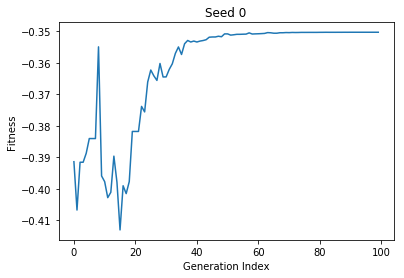

In [14]:
fig, axes = plt.subplots()
axes.plot(best_arr[:,3])
axes.set_xlabel('Generation Index')
axes.set_ylabel('Fitness')
axes.set_title('Seed {}'.format(seed))
plt.show()

In [15]:
fittest = best_arr[np.argmax(best_arr[:,3])]
print('Fittest individual appears in the {}-th generation: P={:.2f}, K={:.2f}, phi={:.2f}, error={:.2f}'.format(
    np.argmax(best_arr[:,3]), fittest[0], fittest[1], fittest[2], -fittest[3]))

Fittest individual appears in the 98-th generation: P=30475619.98, K=0.07, phi=2.77, error=0.35


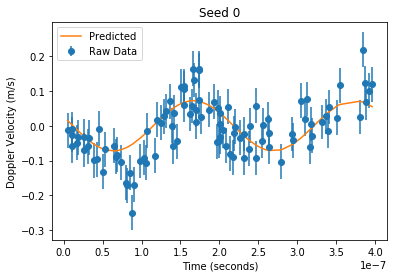

In [16]:
fig, axes = plt.subplots()
axes.errorbar(x=df['time'], y=df['velocity'], yerr=df['error'], fmt='o', label='Raw Data')
axes.plot(df['time'], sin_function(best_arr[np.argmax(best_arr[:,3])][:3]), label='Predicted')
axes.set_xlabel('Time (seconds)')
axes.set_ylabel('Doppler Velocity (m/s)')
axes.set_title('Seed {}'.format(seed))
axes.legend()
plt.show()

| Seed | P    | K    | $\phi$ | Fitness |
|------|------|------|--------|---------|
|   0  |30475619.98|0.07|2.77|-0.35|
|   1  |30198705.35|0.06|2.81|-0.36|
|   2  |28771554.53|0.09|3.14|-0.38|

In [ ]:
param = np.array([30475619.98, 0.07, 2.77])
param_arr = []

